# Auxiliary Functions

This notebook will you through a few auxiliary functions provided by UniTVelo. They are used to facilitate the RNA velocity research and relevant analysis when hardware is a bottleneck, especially GPU resources. The script of choosing the suitable modes is also provided.

We will use human erythroid development dataset in this tutorial (4 clusters & 37k cells in total).

## Choose suitable modes

UniTVelo has two separate modes for users to choose. Although unified-time mode is recommended and is also the default setting of UniTVelo, independent mode has better performance in certain scenarios.

We define two special scenarios when independent time should be used (see Methods section of manuscript), and we provide a reference script `utv.utils.choose_mode(adata, label)` for choosing modes,
- Datasets with cell cycle phase included.
- Datasets with very sparse cell types visualized in low dimentional embeddings.

This script should work as a reference only. Sometimes both modes should be tried.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import unitvelo as utv
import scvelo as scv
scv.settings.verbosity = 0
label = 'type2'

In [2]:
adata = scv.read('../data/Melania/adata_human_def.h5')
utv.utils.choose_mode(adata, label)

This function works as a reference only.
For less certain scenario, we also suggest user to try both.
---> Checking cell cycle scores...
---> Number of S genes 0/43
---> Number of G2M genes 0/54
# of cycle genes failed to pass thresholds
---> Checking sparse cell types...
Unified-time mode is recommended, consider setting config.FIT_OPTION = 1


## Down-sampling adata

We provide an utility script for down-sampling large-scale datasets if hardware is bottleneck (e.g., GPU resources). The script considers rare cell type by setting a parameter specifying minimal number of cells to keep for each cluster. 

This is a random sampling process without replacement, and is controlled by celltype labels, sampling proportion and minimal number of cells within each cluster (`utv.utils.subset_adata(adata, label, proporiton, min_cells)`). 

In [3]:
adata = scv.read('../data/Melania/adata_human_def.h5')
adata

AnnData object with n_obs × n_vars = 35877 × 32738
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

The original data should be normalized first and the moments should be computed as well, before performing down-sampling procedure to ensure data were in the same scale.

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1200)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

In [5]:
adata_subset = utv.utils.subset_adata(adata, label, proportion=0.1)
adata_subset

View of AnnData object with n_obs × n_vars = 3586 × 1200
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'cid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'connectivities', 'distances'

In [9]:
config = utv.config.Configuration()

config.R2_ADJUST = True
config.IROOT = 'MEMP'
config.FIT_OPTION = '1'
config.N_TOP_GENES = 1200

In [ ]:
adata_subset = utv.main.run_model(adata_subset, label, config_file=config, normalize=False)
# adata_subset = scv.read('./res/temp/temp.h5ad')

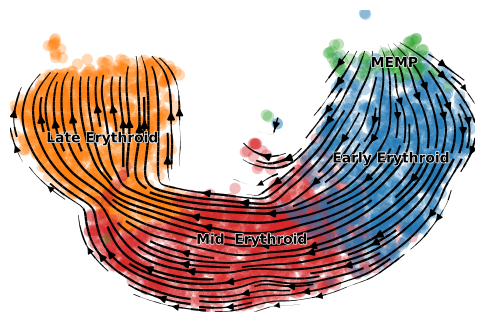

In [29]:
scv.pl.velocity_embedding_stream(adata_subset, color=label, title='', dpi=100)

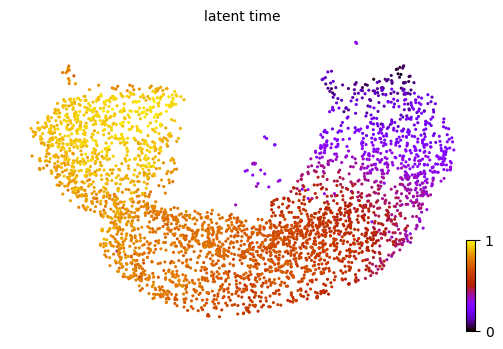

In [28]:
scv.pl.scatter(adata_subset, color='latent_time', color_map='gnuplot', size=20, dpi=100)

## Prediction using subsets

After down-sampling the adata, we could predict the inferred global cell time, velocities and other parameters for other cells using script `utv.utils.subset_prediction(adata_subset, adata)`.

In [24]:
adata = utv.utils.subset_prediction(adata_subset, adata, config=config)

C1orf186
HBD
FLI1
HDC
LPCAT2
RAB34
TPM4
NRIP1
ERG
CD74
BASP1
XXbac-BPG13B8.10
LST1
TBXAS1


  0%|          | 0/35877 [00:00<?, ?cells/s]

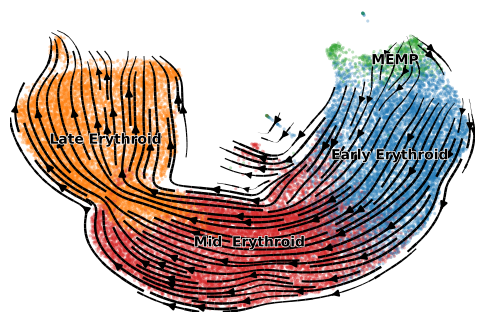

In [32]:
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title='', size=20)

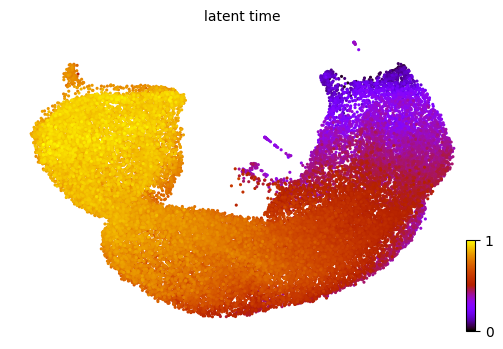

In [35]:
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20, dpi=100)

## Performance comparison

We have already generated a reference dataset using full batch. We will compare the results of the predicted data and full batch optimization. 

In [ ]:
reference = scv.read('./res/temp/erythroidhuman1.h5ad')

Firstly, the inferred global cell time is compared, which represents cells' internal clock in the entire biological process. From the results we could conclude that the down-sampling strategy works quite well on estimating cell time based on a small fration of total cells.

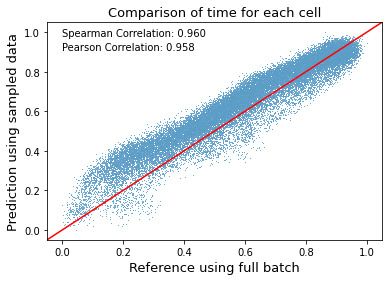

In [95]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x=reference.obs['latent_time'].values, y=adata.obs['latent_time'].values, s=1)
ax.axline((0, 0), (0.5, 0.5), color='r')
ax.set(xlabel=None)
ax.set_ylabel('Prediction using sampled data', fontsize=13)
ax.set_xlabel('Reference using full batch', fontsize=13)
ax.set_title('Comparison of time for each cell', fontsize=13)
plt.text(0, 0.98, 'Spearman Correlation: 0.960', fontsize=10)
plt.text(0, 0.91, 'Pearson Correlation: 0.958', fontsize=10)
plt.savefig('./figures/celltimecompare.png', dpi=300, bbox_inches='tight')

In [84]:
from scipy.stats import spearmanr
results, _ = spearmanr(reference.obs['latent_time'].values, adata.obs['latent_time'].values)
results

0.9603340935846724

In [85]:
from scipy.stats import pearsonr
results, _ = pearsonr(reference.obs['latent_time'].values, adata.obs['latent_time'].values)
results

0.9582649878018394

Secondly, we compare the predicted velocities using down-sampled data and that using full batch. For now we will calculate the cosine similarity of the high dimension velocities of each gene and cell between prediction and reference.

In [47]:
index = reference.var.loc[reference.var['velocity_genes'] == True].index.intersection(adata.var.loc[adata.var['velocity_genes'] == True].index)
reference_velo = reference[:, index].layers['velocity']
adata_velo = adata[:, index].layers['velocity']

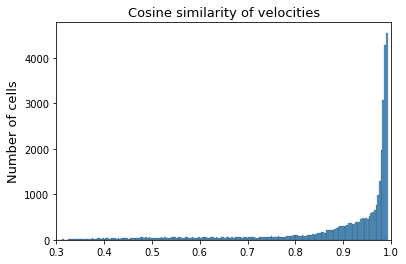

In [103]:
from scipy.spatial.distance import cosine
res_cos = []

for i in range(reference_velo.shape[0]):
    res_cos.append(1 - cosine(reference_velo[i, :], adata_velo[i, :]))
    
ax = sns.histplot(res_cos, bins=200)
ax.set(xlabel=None)
ax.set_ylabel('Number of cells', fontsize=13)
ax.set_xlabel('')
ax.set_title('Cosine similarity of velocities', fontsize=13)
plt.xlim([0.3, 1])
plt.savefig('./figures/cosine.png', dpi=300, bbox_inches='tight')